## Introduction
This notebook introduces the **Normalised Burn Ratio** (NBR), a key index used in satellite remote sensing to assess burn severity. The **NBR** quantifies the severity of damage from wildfires. The NBR is calculated using near-infrared and shortwave infrared bands from Sentinel-2 Level 2 data to highlight vegetation and burned areas.

Based on the NBR, we can calculate the differenced Normalized Burn Ratio (dNBR) which is a strong indicator of the severity of a fire's impact on vegetation. The index can be interpreted as follows:
* **High dNBR** values suggest high burn severity,
* **Low dNBR** values indicate low burn severity or minimal damage, and
* **Zero or negative dNBR** can indicate areas unaffected by the fire or even areas of regrowth following a fire.

To calculate the dNBR, we will first calculate the NBR **before** and **after** a fire event.
The post-fire NBR image is then subtracted from the pre-fire NBR image to produce the dNBR image.

This notebook is the second a series of three notebook:
* [Part 1 - Compare Sentinel-2 True- and False-Color composites before and after a fire event](./511_s2_tfci.ipynb)
* [Part 2 - Analyse fire intensity with Sentinel-2 and -3 data](./512_s3_lst.ipynb)
* **Part 3 - Assess burn severity with the normalised burn ratio (dNBR)**


###  What we will learn

- 🛰️ Access, compute and relate the **SWIR** and **NIR** bands from Sentinel-2 mission
- 🔎 Explore how to process and georeference the values inside a `.zarr` asset
- 🔥 Complement **pre** and **post** fire analysis with **quantitative analysis**

<hr>

#### Import libraries

In [1]:
from distributed import LocalCluster
from pystac_client import Client
import numpy as np
import xarray as xr
import dask.array as da 
import time
import matplotlib.pyplot as plt
from pyproj import Transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm, ListedColormap
from shapely.geometry import box 

/opt/conda/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


#### Helper functions

This notebook makes use of a set of functions that are all listed inside the [zarr_wf_utils.py](./zarr_wf_utils.py) script. Inside the script, we will find costumised functions that allow us to mask, normalise and extract specific areas of our items of interest.

In [2]:
from zarr_wf_utils import (
    validate_scl_w,
    mask_sub_utm,
    lat_lon_to_utm_box,
    zarr_mask_utm
)

<hr>

## Setting up the environment

### Initiate a Dask cluster

The first step is to initiate a virtual Dask cluster consisting of a scheduler that manages tasks and multiple workers that process them.

In [3]:
cluster = LocalCluster()
client = cluster.get_client()
client

/opt/conda/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38621 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38621/status,
Dashboard: http://127.0.0.1:38621/status,Workers: 4
Total threads: 4,Total memory: 15.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33035,Workers: 0
Dashboard: http://127.0.0.1:38621/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37755,Total threads: 1
Dashboard: http://127.0.0.1:41715/status,Memory: 3.81 GiB
Nanny: tcp://127.0.0.1:39507,


### Define workflow variables

Following [Part 1](511_s2_tfci.ipynb) of, we need to define the specific **spatial** and **temporal** parameters for our analysis. We will set the same area of interest over the Province of Nuoro Sardinia, Italy. We define the dates for our pre-fire and post-fire period.

According to [EFFIS's definition](https://forest-fire.emergency.copernicus.eu/about-effis/technical-background/fire-severity#:~:text=The%20proposed%20methodology%20is%20recommended,and%20post%2Dfire%20NBR%20composites.), the **severity** for each fire is calculated after **30 days of the date of the fire**, and it can be classified as follows:

| Class | dNBR range (multiplied by 1000) |
|:---|:---|
| Unburned or Regrowth | < 100 |
| Low severity | 100 - 270 |
| Moderate low severity | 270 - 440 |
| Moderate high severity | 440 - 660 |
| High severity | >= 660 |

For the pre-fire state, we will use an image from **3rd of June 2025**, and due to data avilability, the closest available image for post fire state is set to **3rd July 2025**. Additional information such as CRS and the relevant Sentinel-2 Level 2 bands, **Near Infra Red** (NIR) (B8a) and **Short Wave Infrared** (SWIR) (B12), are set.

In [ ]:
# Dates of interest
# Before the fire:
pre_f  = '2025-06-03'
# After the fire:
post_f = '2025-07-03'

# The area of interest for our filtering
bbox = (8.847198,40.193395,
        8.938865,40.241895)

# Definition of the transformer parameters for reprojection and correct overlay of layers
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32632", always_xy=True)
t_utm_to_deg = Transformer.from_crs("EPSG:32632","EPSG:4326", always_xy=True)

# The false colour channels we are interested to retrieve coposite:
swir = 'b12'
nir =  'b8a'

# Defining a larger bounding box for better visualisation:
bbox_vis = (8.649555,40.073583,
          9.127893,40.343840)

# A fixed geographic bounding box to highlight the AOI in the map format
map_box = bbox
# A new list with the converted UTM coordinates
bbox_utm = lat_lon_to_utm_box((bbox_vis[0], bbox_vis[1]),(bbox_vis[2], bbox_vis[3]),transformer)

def_collection = 'sentinel-2-l2a' #collection

# we are interested in the performance the code will have
st = time.time()

### Establish a connection to the EOPF STAC Catalog


Additionally, we also need to establish a connection to the EOPF STAC catalog.

In [5]:
eopf_stac_api_root_endpoint = "https://stac.core.eopf.eodc.eu/" #root starting point
eopf_catalog = Client.open(url=eopf_stac_api_root_endpoint) # calls the selected url
eopf_catalog

<Client id=eopf-sample-service-stac-api>

## Calculation of NBR - Pre-Fire

Now we can use our defined parameters to query the STAC catalog and to retrieve all available **Sentinel-2** imagery that correspond to our query arguments.

In [9]:
# We define the search over the whole day, from 12:00 am to 11:59 pm
date_pre = pre_f + 'T00:00:00Z/' + pre_f + 'T23:59:59.999999Z' # interest period

s2_pre = list(eopf_catalog.search(
                bbox= bbox, 
                datetime= date_pre,
                collections=def_collection).item_collection())

av_urls = [item.assets["product"].href for item in s2_pre]
av_urls

['https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202506-s02msil2a/03/products/cpm_v256/S2A_MSIL2A_20250603T101041_N0511_R022_T32TMK_20250603T134103.zarr']

Now we open the retrieved item as a xarray.DataTree. This image will serve as our baseline for the pre-fire conditions, providing a clean snapshot of the landscape before the event.
We extract the `r20m` group under measurements group, as this is the resolution we will be focusing on. We also mask out all invalid pixels by applying the function `validate_scl()`.

In [ ]:
# Open the last Zarr item from the list of URLs as a data tree.
pre_zarr = xr.open_datatree(
    av_urls[0], engine="zarr",
    chunks={},
    )

# Select the 20m reflectance measurements from the data tree.
zarr_meas_pre = pre_zarr.measurements.reflectance.r20m

# Extractthe cloud free mask at 20m resolution:
l2a_class_20m_pre = pre_zarr.conditions.mask.l2a_classification.r20m.scl
valid_mask_pre = validate_scl_w(l2a_class_20m_pre)  # Boolean mask

To calculate the **Normalised Burn Ratio** (NBR), we will access the specific spectral bands we need: the **Near-Infrared** (NIR) band (B8A) and the **Shortwave Infrared** (SWIR) band (B12).

Once we access them, we need to ensure our data features our area of interest (AOI). We will apply the same **masking** and **clipping** functions used in our [previous tutorial](512_s3_lst.ipynb) to clip the imagery to our precise `bbox_utm`.

In [12]:
# Create UTM masks for rows and columns based on the bounding box.
rows_pre, cols_pre= zarr_mask_utm (bbox_utm, zarr_meas_pre)

# Extract and slice the y-dimension values from the Zarr measurement.
y_zarr = zarr_meas_pre['y'].isel(y=slice(rows_pre.min(), rows_pre.max() + 1)).values
# Extract and slice the x-dimension values from the Zarr measurement.
x_zarr = zarr_meas_pre['x'].isel(x=slice(cols_pre.min(), cols_pre.max() + 1)).values

# Select the red, green, and blue bands and apply the valid mask.
swir_pre = zarr_meas_pre[swir].where(valid_mask_pre)
nir_pre =  zarr_meas_pre[nir].where(valid_mask_pre)

# Mask and clip the selected bands using the row and column indices.
swir_pre = mask_sub_utm(swir_pre,rows_pre, cols_pre).values
nir_pre = mask_sub_utm(nir_pre,rows_pre, cols_pre).values

Once we obtain the masked assets, we can visualise them before calculating the **NBR**.

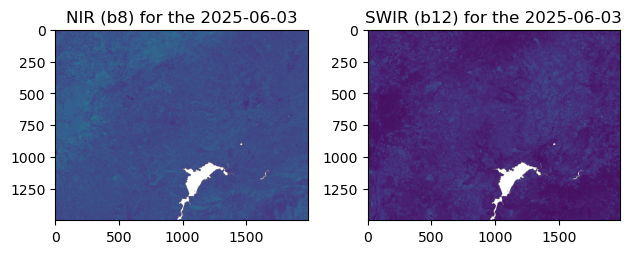

In [13]:
# Create a figure to plot
fig, axs = plt.subplots(1, 2)
axs[0].imshow(nir_pre)
axs[0].set_title(f'NIR (b8) for the {pre_f}')
# Plot the filtered land surface temperature data on the second subplot
axs[1].imshow(swir_pre)
axs[1].set_title(f'SWIR (b12) for the {pre_f}') # Add a title for clarity
# Adjust the layout
fig.tight_layout()
# Display the plot
plt.show()

With our `swir_pre` and `nir_pre` bands ready, we can now calculate the pre-fire NBR image.
We will apply the following NBR formula:

$$\frac{(NIR - SWIR)} {(NIR + SWIR)}$$

An important consideration for this process is the possibility of division by zero when calculating the composite. To prevent this, we create a mask that assigns a value of `1` to any pixel that is `0`, while keeping the original values for all other pixels.

In [14]:
# We calculate the nbr for our pre fire event
pre_difference = nir_pre - swir_pre

# to deal with 0 divisions on the NBR formula

pre_addition = nir_pre + swir_pre

# we create a mask to detect possible 0 values
zero_mask = (pre_addition == 0)
pre_z= pre_addition.copy()

pre_z = da.where(pre_addition == 0, 1, pre_z)


# Calculatig our NBR for the moment before the fire:

nbr_pre  = da.where(pre_addition == 0, 0, pre_difference / pre_z)

Now, we can visualise the calculated pre-fire NBR image.

/opt/anaconda3/envs/eopf_env_wf/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 48.11 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Text(0.5, 1.0, 'NBR from the 2025-06-03')

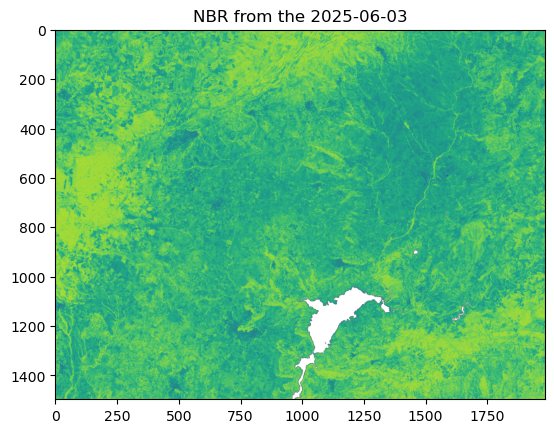

In [15]:
# Visualising the clipped red band:
plt.imshow(nbr_pre, vmin=-1.0, vmax=1.0)
plt.title(f'NBR from the {pre_f}')

## Calculation of NBR - Post-Fire

The next step is to repeat the same steps as above and to calculate a **post-fire** NBR image.

We first query the EOPF STAC catalog for items avialble on 3 July 2025, open the retrieved item as xarray.DataTree and mask out invalid pixels.

In [ ]:
# We define the search over the whole day, from 12:00 am to 11:59 pm
date_post = post_f + 'T00:00:00Z/' + post_f + 'T23:59:59.999999Z' # interest period

s2_post = list(eopf_catalog.search(
                bbox= bbox, 
                datetime= date_post,
                collections=def_collection).item_collection())

av_urls = [item.assets["product"].href for item in s2_post]

post_zarr = xr.open_datatree(
    av_urls[-1], engine="zarr", #we always get the earliest one (last)
    chunks={},
    )

zarr_meas_post = post_zarr.measurements.reflectance.r20m

# Extractthe cloud free mask at 20m resolution:
l2a_class_20m_post = post_zarr.conditions.mask.l2a_classification.r20m.scl
valid_mask_post = validate_scl_w(l2a_class_20m_post)  # Boolean mask

In a next step, we follow the same **masking** and **clipping** functions to this new dataset to ensure it is focused on our area of interest.

In [17]:
# Create UTM masks for rows and columns based on the bounding box.
rows_post, cols_post= zarr_mask_utm(bbox_utm, zarr_meas_post)

# Slice the y-dimension values using the new row indices.
y_zarr = zarr_meas_post['y'].isel(y=slice(rows_post.min(), rows_post.max() + 1)).values
# Slice the x-dimension values using the new column indices.
x_zarr = zarr_meas_post['x'].isel(x=slice(cols_post.min(), cols_post.max() + 1)).values

# define our zarr extracted coordinates
map_ext_deg = list(t_utm_to_deg.transform(np.nanmin(x_zarr),np.nanmin(y_zarr)) + 
                   t_utm_to_deg.transform(np.nanmax(x_zarr),np.nanmax(y_zarr)))

# Select the red, green, and blue bands and apply the valid mask.
swir_post = zarr_meas_post[swir].where(valid_mask_post)
nir_post =  zarr_meas_post[nir].where(valid_mask_post)

# Mask and clip the selected bands using the row and column indices.
swir_post = mask_sub_utm(swir_post,rows_post, cols_post).values
nir_post = mask_sub_utm(nir_post,rows_post, cols_post).values


After our masking, we obtain the following bands

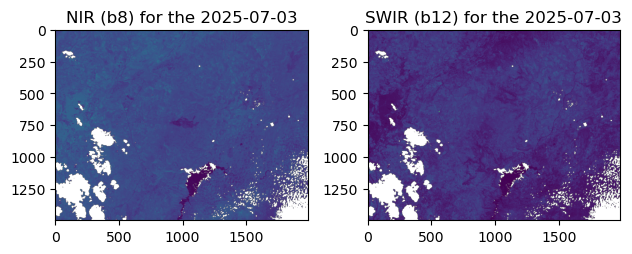

In [18]:
# Create a figure to plot
fig, axs = plt.subplots(1, 2)
axs[0].imshow(nir_post)
axs[0].set_title(f'NIR (b8) for the {post_f}')
# Plot the filtered land surface temperature data on the second subplot
axs[1].imshow(swir_post)
axs[1].set_title(f'SWIR (b12) for the {post_f}') # Add a title for clarity
# Adjust the layout
fig.tight_layout()
# Display the plot
plt.show()

With our post-fire bands, we can now calculate the Post-Fire NBR. We apply the **0** division consideration masking and the **NBR** formula again to these bands to get the post-fire **NBR** image.

/opt/anaconda3/envs/eopf_env_wf/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 48.11 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Text(0.5, 1.0, 'NBR from the 2025-07-03')

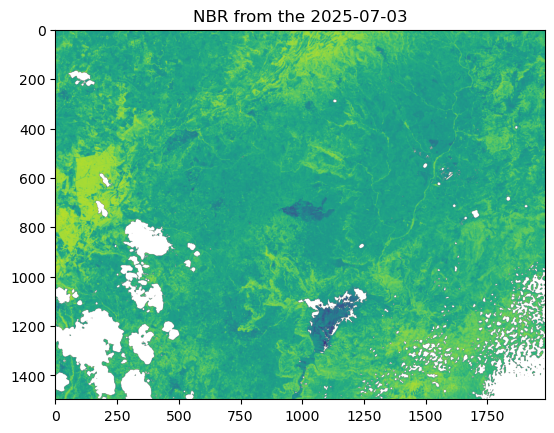

In [19]:
# We calculate the nbr for our post fire event
post_difference = nir_post - swir_post

# to deal with 0 divisions on the NBR formula
post_addition = nir_post + swir_post

# we create a mask to detect possible 0 values
zero_mask = (post_addition == 0)
post_z= post_addition.copy()

post_z = da.where(post_addition == 0, 1, post_z)

nbr_post  = da.where(post_addition == 0, 0, post_difference / post_z)

# Visualising the clipped red band:
plt.imshow(nbr_post, vmin=-1.0, vmax=1.0)
plt.title(f'NBR from the {post_f}')


## Calculate Differenced NBR (dNBR)

The last calculation step for our analysis is the **delta NBR** (dNBR). This index is calculated by **subtracting** the **post-fire** NBR **from** the **pre-fire** NBR. Higher dNBR values indicate more severe damage, providing a quantitative measure of the fire's impact.

$$dNBR = prefireNBR - postfireNBR$$

In [ ]:
# Calculate the delta Normalised Burn Ratio (dNBR) by subtracting the post-fire NBR from the pre-fire NBR.
dNBR = (nbr_pre - nbr_post) * 1000

# bringing the dNBR to memory
dNBR_c = dNBR.compute()

As our calculation was based on dask array for a faster computation, we bring it back to memory and multiply it by 1000 to be able to compare it to **Key & Benson (2006) severity thresholds**, proposed by [EFFIS](https://forest-fire.emergency.copernicus.eu/about-effis/technical-background/fire-severity#:~:text=The%20proposed%20methodology%20is%20recommended,and%20post%2Dfire%20NBR%20composites).

Text(0.5, 1.0, 'Calculated dNBR')

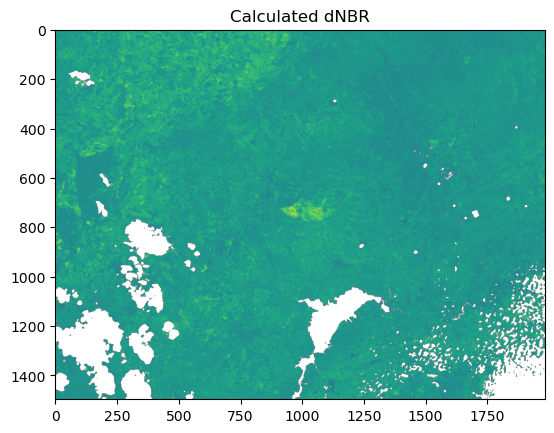

In [21]:
# Visualising the clipped red band:
# plt.imshow(dNBR)
plt.imshow(dNBR, vmin=-1000.0, vmax=1000.0)
plt.title(f'Calculated dNBR')

Finally, we will plot our results to visualise the **burn severity**. Using the `cartopy` library, we can create a georeferenced map that accurately displays our data based on its CRS and geospatial bounding box.

The **dNBR** data will be presented on this map using a colour scheme that clearly highlights the most affected areas by the fire.

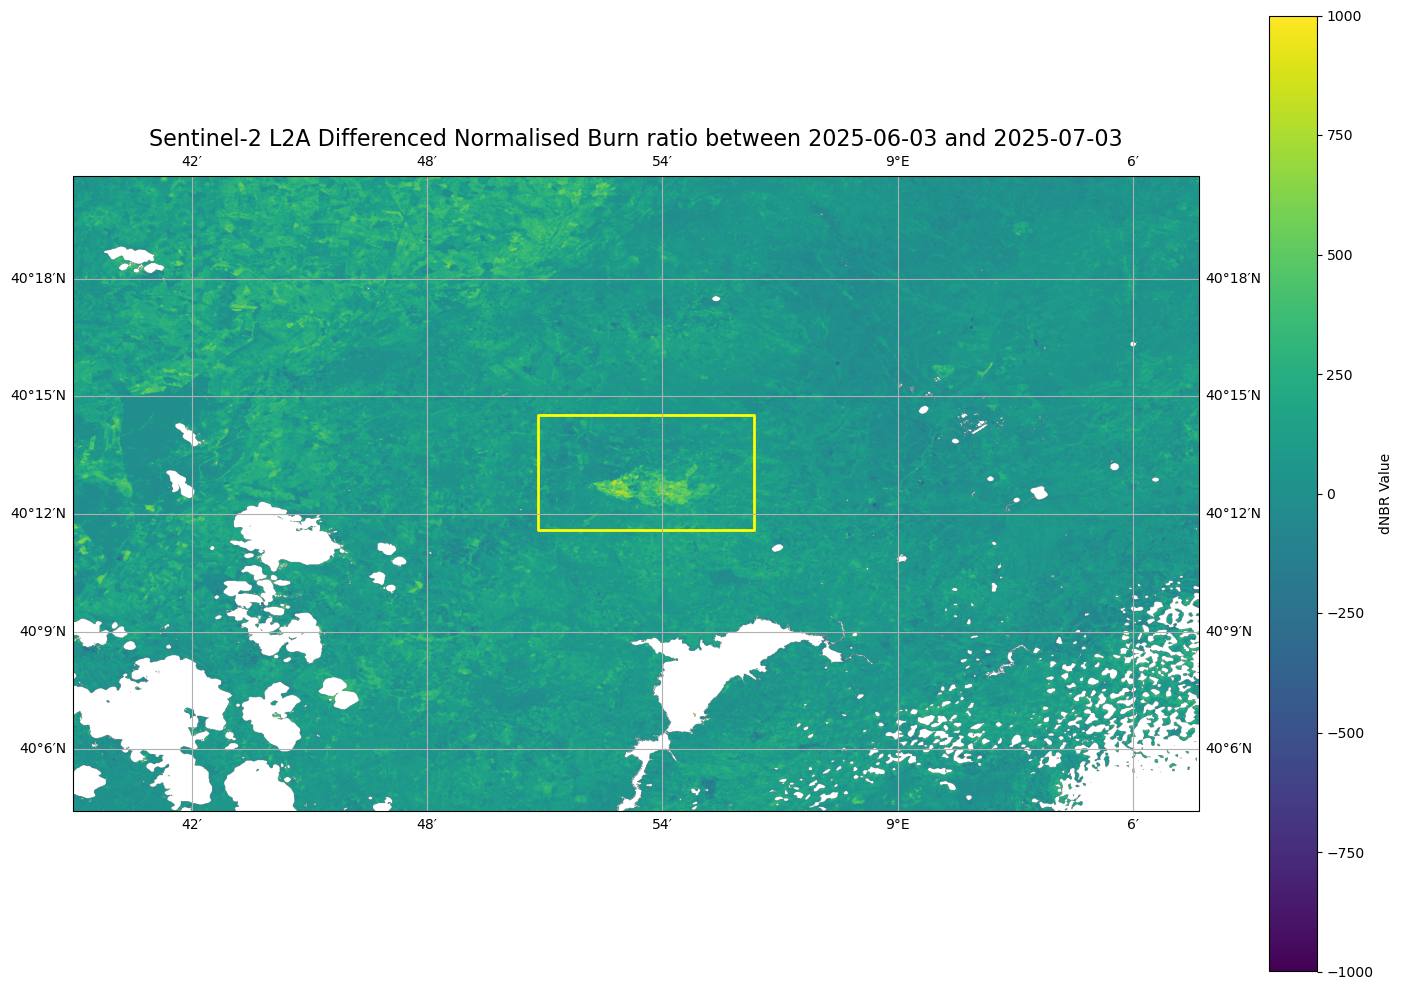

In [ ]:
# Creating the Geometry
map_box = box(map_box[0],map_box[1],map_box[2],map_box[3])

#Overlay
plt.figure(figsize=(15, 10))
# Create a figure with a specified size.
data_ll = ccrs.PlateCarree()
# Set up the plot with a defined projection.
ax = plt.axes(projection=data_ll)

# Display the Differenced Normalised Burn Ratio (dNBR)
im = ax.imshow(dNBR_c, origin='upper',
                extent=(bbox_vis[0],bbox_vis[2],
                        bbox_vis[1],bbox_vis[3]),  # item
                         vmin=-1000.0, vmax=1000.0,
                transform=data_ll)

# features
plt.colorbar(im, ax=ax, label='dNBR Value')
ax.add_geometries([map_box], crs=data_ll, facecolor='none', edgecolor='yellow', linewidth=2, linestyle='-')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False) # Add gridlines and labels


# Set the title of the plot.
plt.title(f'Sentinel-2 L2A Differenced Normalised Burn ratio between {pre_f} and {post_f}', fontsize=16)
# Adjust plot to ensure all elements fit without overlapping.
plt.tight_layout()
# Show the final plot.
plt.show()

As the plot shows, the burn scar provides a spectral response through **dNBR**, even after the asset was clipped to remove clouds and water bodies.<br>
The **severity** values are **over 750**, which classifies this as being in the high-severity range of Key & Benson (2006).

| Class | dNBR range (multiplied by 1000) |
|:---|:---|
| Unburned or Regrowth | < 100 |
| Low severity | 100 - 270 |
| Moderate low severity | 270 - 440 |
| Moderate high severity | 440 - 660 |
| High severity | >= 660 |


### Calculating processing time

Besides the asset's accessibility, it is important to note the time efficiency of this monitoring workflow. The entire process, from defining the area of interest to searching, accessing, processing, and visualising the data takes **less** than **30 seconds**.<br>

In [22]:
et = time.time()
total_t = et - st
print('Total Running Time: ', total_t,' seconds')

Total Running Time:  24.305949926376343  seconds


<hr>

## Conclusion

This series of notebooks demonstrated a complete workflow for monitoring fire events using data from the Sentinel-2 and Sentinel-3 missions, providing a comprehensive view of the wildfire stages, **before**, **during** and **after**.

By leveraging the cloud-optimised `zarr` format, we have shown how **visual** and **quantitative** composites, plus **multisource integration** can provide a clear and repeatable method for assessing the severity of a wildfire occurrence.

Unlike previous workflows, which required the local downloading and processing of large `.TIFF` images, the `.zarr` format, available through the [EOPF STAC Catalog](https://stac.browser.user.eopf.eodc.eu/?.language=en), enables users to filter and access data without having to manage massive datasets locally. Furthermore, the ability to replicate defined steps at various points in time provides a robust framework for comprehending the entire fire life cycle.


<hr>

## What’s next?

This online resource is under active development. So stay tuned for regular updates.